In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os, sys, cv2



%load_ext autoreload
%autoreload 2

import nncv, mmcv
import os.path as osp
from PIL import Image
import random
import torch
import torch.nn as nn


In [3]:
root = '/home/user/data/tianchi/logdet/train'

# 图像尺寸和长宽比

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2477/2477, 1734.0 task/s, elapsed: 1s, ETA:     0s


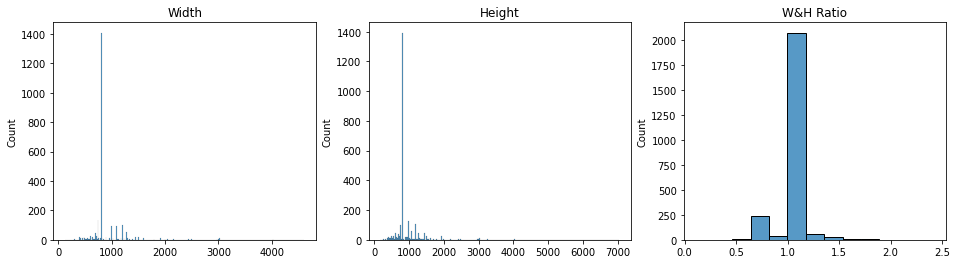

In [4]:
img_dir = osp.join(root, 'images')
import glob
import mmcv
img_paths = glob.glob(img_dir + '/*')
def get_img_size(img_path):
    image = Image.open(img_path)
    w, h = image.size
    return (w, h)

results = mmcv.track_parallel_progress(get_img_size, img_paths, 8)

w_list = [x[0] for x in results]
h_list = [x[1] for x in results]

import seaborn as sns
f, ax = plt.subplots(1,3, figsize=(16,4))
sns.histplot(w_list, ax=ax[0], palette=sns.light_palette("seagreen", as_cmap=True)).set_title('Width');
sns.histplot(h_list, ax=ax[1], palette=sns.color_palette("RdPu", 10)).set_title('Height');
sns.histplot(np.array(w_list)/np.array(h_list), ax=ax[2], palette=sns.color_palette("RdPu", 10)).set_title('W&H Ratio');

In [6]:
from collections import defaultdict
def count_list(xs, top=10):
    # refer: https://stackoverflow.com/questions/2290962/python-how-to-get-sorted-count-of-items-in-a-list
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]
count_list(w_list)

[(800, 1405),
 (750, 127),
 (1200, 97),
 (1080, 95),
 (1000, 91),
 (1280, 40),
 (700, 37),
 (600, 24),
 (1500, 22),
 (1440, 19)]

大部分都是 `800*800` 的 尺寸，少部分会非常大

# 统计小目标的比例

In [7]:
from pycocotools.coco import COCO
json_path = osp.join(root, 'annotations/instances_train2017.json')
coco = COCO(json_path)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [8]:
print('bbox 小目标(area<%3)占比 统计')
class_names = []
wh_ratios_cls = []
for cat_id in coco.cats:
    wh_ratios = []
    for ann_id in coco.getAnnIds(catIds=[cat_id]):
        ann = coco.anns[ann_id]
        image_id = ann['image_id']
        w_ratio = ann['bbox'][2] / coco.imgs[image_id]['width']
        h_ratio = ann['bbox'][3] / coco.imgs[image_id]['height']
        wh_ratios.append([w_ratio, h_ratio])
    wh_ratios = np.array(wh_ratios)
    wh_ratios[:, -1] = wh_ratios[:, 0] * wh_ratios[:, 1]
    # print(coco.cats[cat_id]['name'], (wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])
    class_names.append(coco.cats[cat_id]['name'])
    wh_ratios_cls.append((wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])

wh_ratios = []
for _, ann in coco.anns.items():
    image_id = ann['image_id']
    w_ratio = ann['bbox'][2] / coco.imgs[image_id]['width']
    h_ratio = ann['bbox'][3] / coco.imgs[image_id]['height']
    wh_ratios.append([w_ratio, h_ratio])
wh_ratios = np.array(wh_ratios)
wh_ratios[:, -1] = wh_ratios[:, 0] * wh_ratios[:, 1]
# print('all ', (wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])
class_names.append('all')
wh_ratios_cls.append((wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])

from prettytable import PrettyTable
table_data = PrettyTable()
table_data.add_column('class', class_names)
table_data.add_column('small object ratio', wh_ratios_cls)
print(table_data.get_string())

bbox 小目标(area<%3)占比 统计
+------------------------+---------------------+
|         class          |  small object ratio |
+------------------------+---------------------+
|         冰墩墩         | 0.35398230088495575 |
|       Sanyo/三洋       |         1.0         |
|     Eifini/伊芙丽      |         1.0         |
|      PSALTER/诗篇      |  0.9636363636363636 |
|        Beaster         |       0.84375       |
|        ON/昂跑         |  0.9878048780487805 |
|     BYREDO/柏芮朵      |  0.9568965517241379 |
|         Ubras          |         0.98        |
|       Eternelle        |  0.6326530612244898 |
| PERFECT DIARY/完美日记 |  0.8918918918918919 |
|         花西子         |  0.9897959183673469 |
|     Clarins/娇韵诗     |  0.9734513274336283 |
|   L'occitane/欧舒丹    |  0.9716312056737588 |
|     Versace/范思哲     |  0.8235294117647058 |
|     Mizuno/美津浓      |  0.7520661157024794 |
|      Lining/李宁       |         0.95        |
|    DOUBLE STAR/双星    |  0.5416666666666666 |
|     YONEX/尤尼克斯     |  0.847560975

小目标(area<%3) 占据了大部分

# bbox长宽比

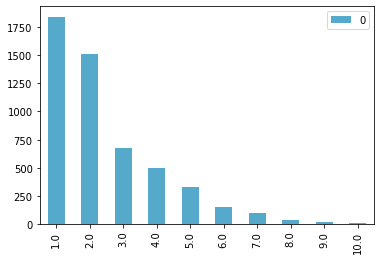

In [9]:
# refer: https://zhuanlan.zhihu.com/p/108885033
bbox_wh = [round(max(ann['bbox'][2], ann['bbox'][3]) / min(ann['bbox'][2], ann['bbox'][3]), 0) for _, ann in coco.anns.items()]
import pandas as pd
bbox_wh_unique = list(set(bbox_wh))
bbox_wh_count=[bbox_wh.count(i) for i in bbox_wh_unique]
k = 10
wh_df = pd.DataFrame(bbox_wh_count[:k], index=bbox_wh_unique[:k])
wh_df.plot(kind='bar',color="#55aacc")
plt.show()

In [10]:
from tqdm import tqdm
imgIds_multiple_cls = []
for imgId in tqdm(coco.getImgIds()):
    anns = coco.imgToAnns[imgId]
    cat_ids = [ann['category_id'] for ann in anns]
    cat_ids_set = set(cat_ids)
    if len(cat_ids_set) != 1:
        imgIds_multiple_cls.append(imgId)
print(len(imgIds_multiple_cls))

100%|██████████| 2476/2476 [00:00<00:00, 553252.18it/s]

0


# 看看每类的数量

In [11]:
class_names = [x['name'] for _, x in coco.cats.items()]
print(len(class_names))
class_nums = [len(coco.getImgIds(catIds=[x])) for x in coco.cats]
for x, y in zip(class_names, class_nums):
    print(x, y)

50
冰墩墩 50
Sanyo/三洋 49
Eifini/伊芙丽 48
PSALTER/诗篇 50
Beaster 50
ON/昂跑 50
BYREDO/柏芮朵 50
Ubras 50
Eternelle 49
PERFECT DIARY/完美日记 50
花西子 45
Clarins/娇韵诗 50
L'occitane/欧舒丹 48
Versace/范思哲 50
Mizuno/美津浓 50
Lining/李宁 50
DOUBLE STAR/双星 50
YONEX/尤尼克斯 50
Tory Burch/汤丽柏琦 50
Gucci/古驰 49
Louis Vuitton/路易威登 50
CARTELO/卡帝乐鳄鱼 50
JORDAN 50
KENZO 50
UNDEFEATED 50
BOY LONDON 50
TREYO/雀友 50
carhartt 50
洁柔 50
Blancpain/宝珀 49
GXG 48
乐町 47
Diadora/迪亚多纳 50
TUCANO/啄木鸟 50
Loewe 50
Granite Gear 50
DESCENTE/迪桑特 49
OSPREY 50
Swatch/斯沃琪 50
erke/鸿星尔克 50
Massimo Dutti 49
PINKO 50
PALLADIUM 50
origins/悦木之源 50
Trendiano 50
音儿 47
Monster Guardians 50
敷尔佳 50
IPSA/茵芙莎 50
Schwarzkopf/施华蔻 49


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


<Figure size 432x288 with 0 Axes>

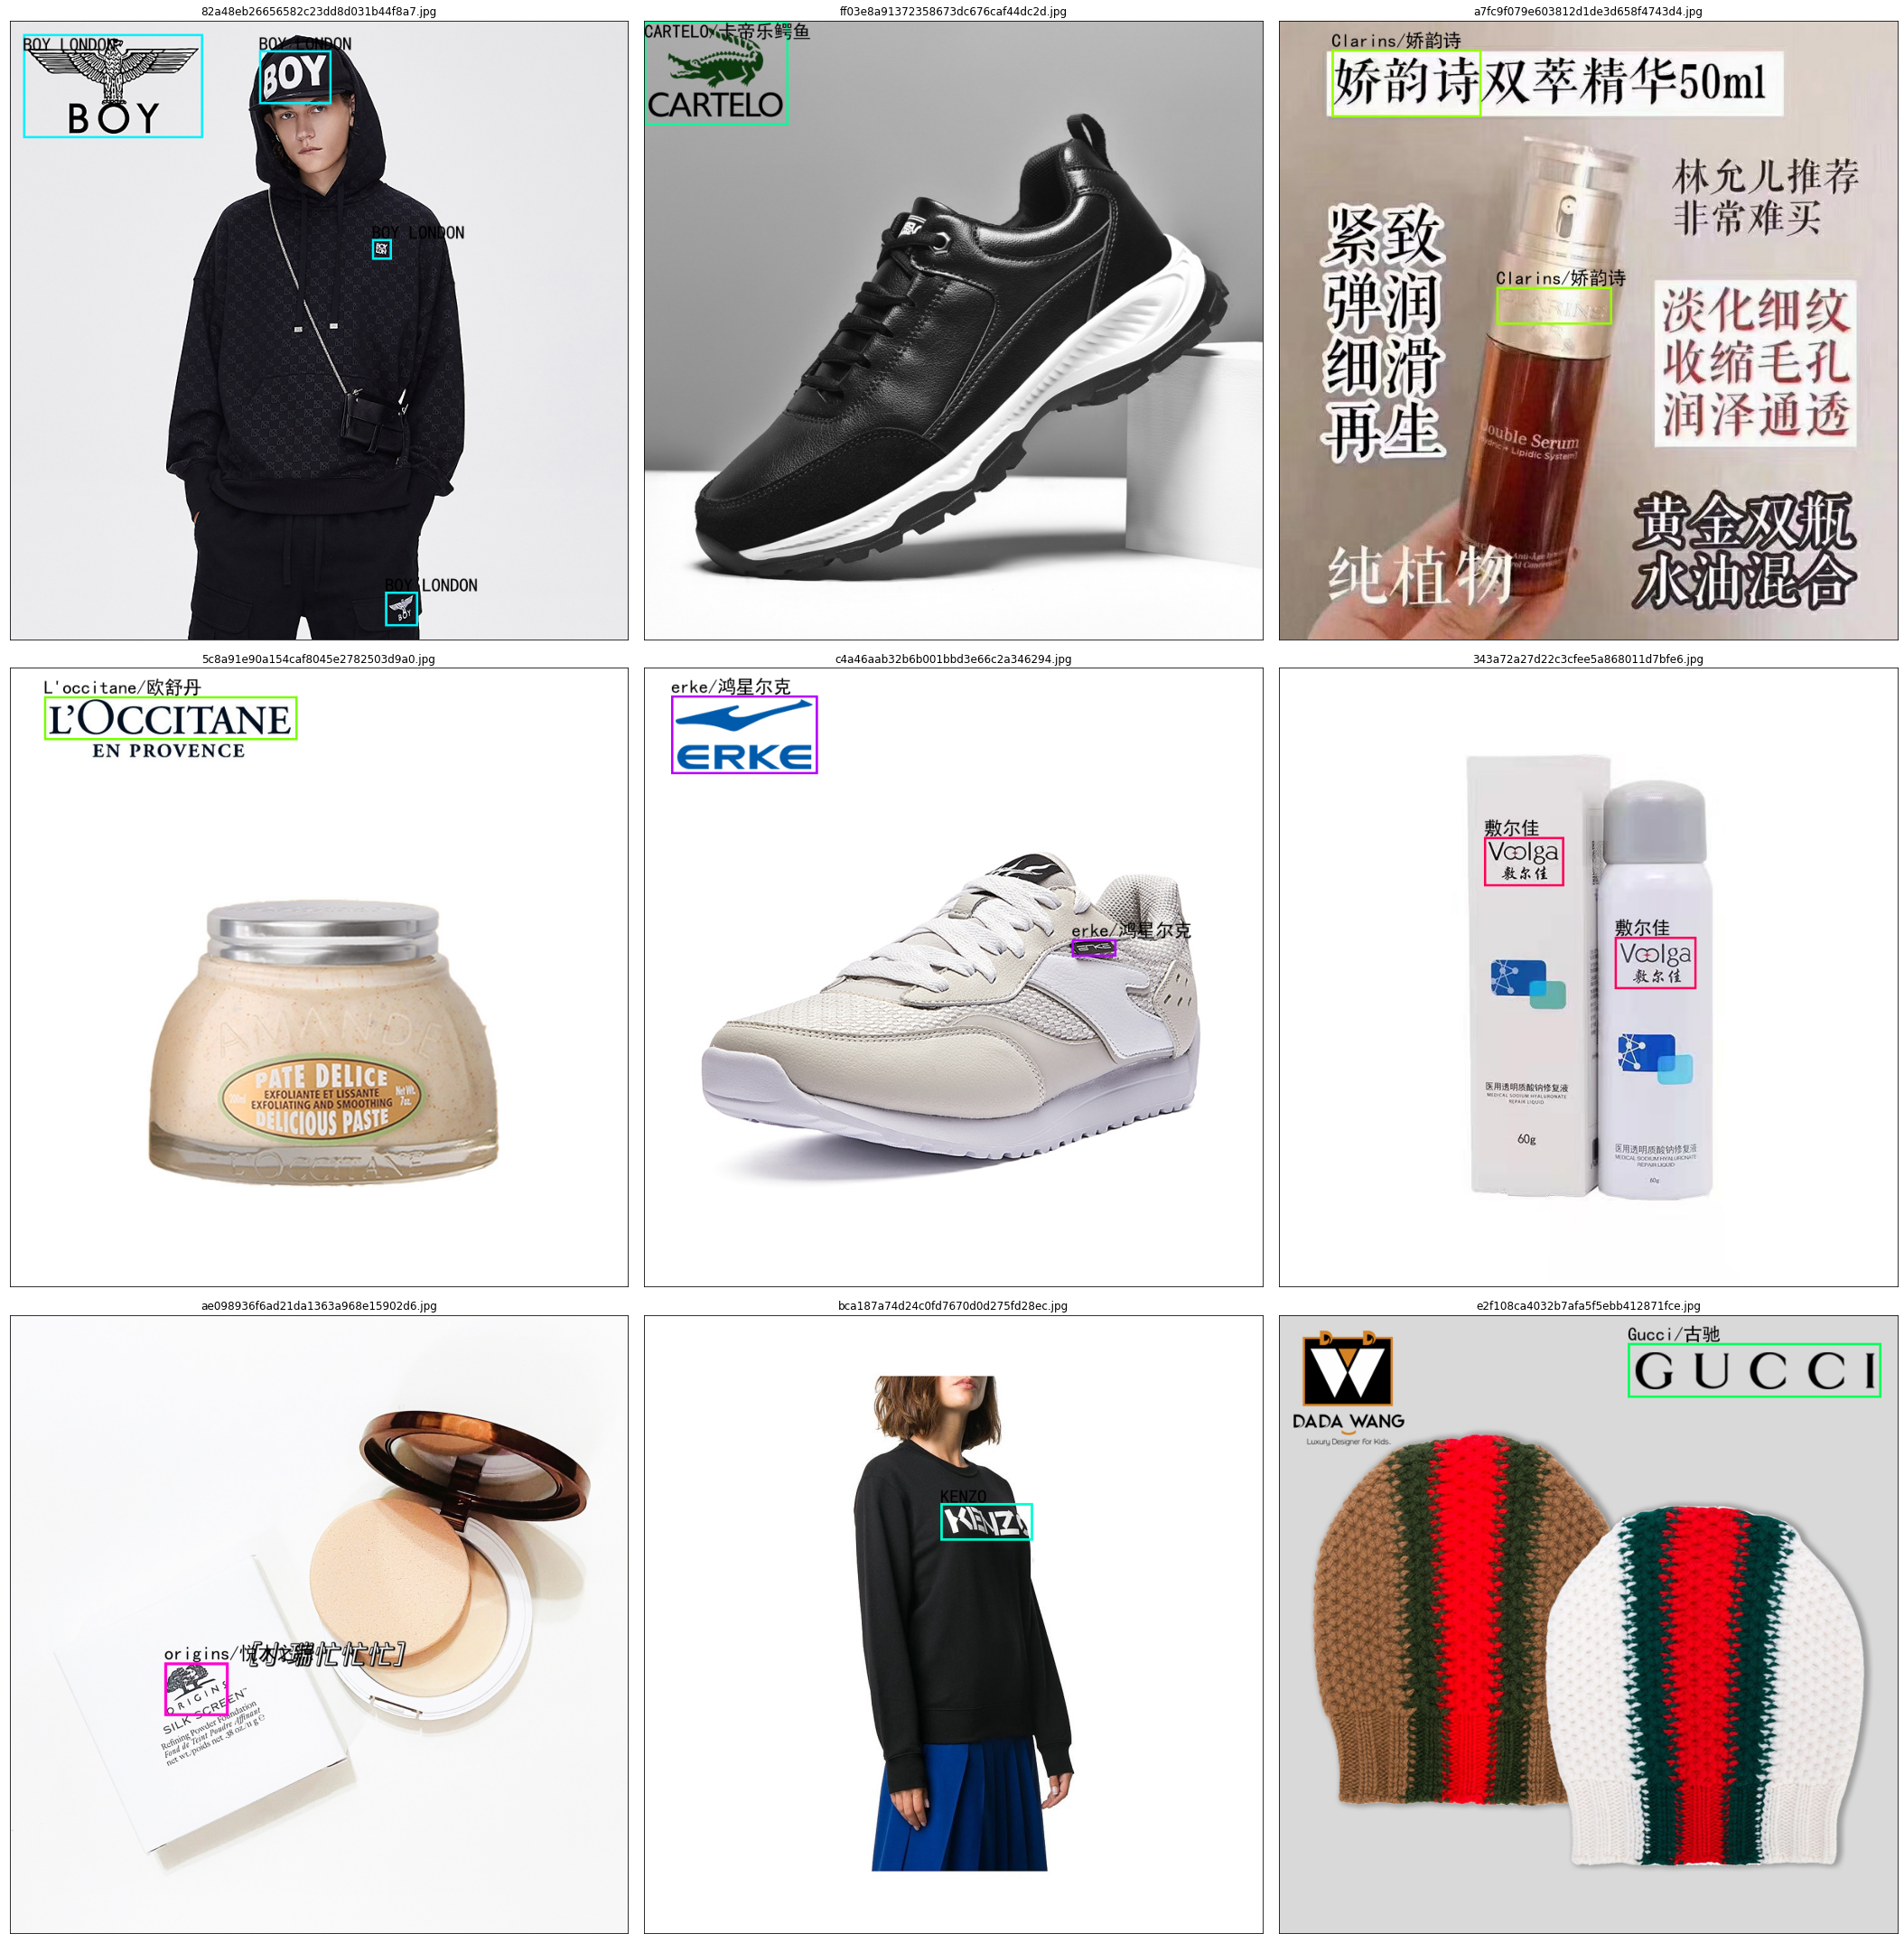

In [12]:
from nncv.coco import vis_coco_batch
vis_coco_batch(osp.join(root, 'annotations/instances_train2017.json'), osp.join(root, 'images'))